In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import torch
from torch import nn

# データ読み込み

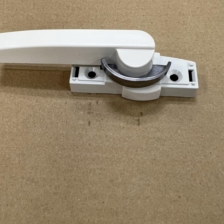

In [ ]:
class TestTransform():
  def __init__(self):
    self.data_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
    ])
  def __call__(self, img):
    return self.data_transform(img)
test_images=datasets.ImageFolder( "/content/drive/MyDrive/signate/タナチョー 部材の画像認識/train", transform = TestTransform())

test_images[0][0]

# 背景除去 RemoveBackground rb

In [ ]:
import cv2
from google.colab.patches import cv2_imshow

## 前処理

In [ ]:
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Subset

class RBPreprocess():
  def __init__(self):
    self.data_transform = transforms.Compose([
        transforms.Resize(320),
        transforms.CenterCrop(320),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
  def __call__(self, img):
    return self.data_transform(img)

rb_dataset=datasets.ImageFolder( "/content/drive/MyDrive/signate/タナチョー 部材の画像認識/train", transform = RBPreprocess())



## モデル読み込み

In [ ]:
import torch
import torchvision

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

rb_model = torchvision.models.segmentation.deeplabv3_resnet101(pretrained=True)
rb_model = rb_model.to(device)
rb_model.eval();

with torch.no_grad():
    output = rb_model(rb_dataset[0][0].unsqueeze(0).to(device))

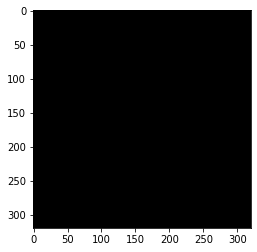

In [ ]:
from PIL import Image
output_predictions=output['out'][0].argmax(0)
palette = torch.tensor([2 ** 25 - 1, 2 ** 15 - 1, 2 ** 21 - 1])
colors = torch.as_tensor([i for i in range(21)])[:, None] * palette
colors = (colors % 255).numpy().astype("uint8")

# plot the semantic segmentation predictions of 21 classes in each color
r = Image.fromarray(output_predictions.byte().cpu().numpy()).resize((320,320))
r.putpalette(colors)

import matplotlib.pyplot as plt
plt.imshow(r)

# DenseNet

## 前処理
https://pystyle.info/pytorch-list-of-transforms/


In [2]:
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Subset

class ImageTransform():
  def __init__(self):
    self.data_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.RandomRotation(degrees=180),
        transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5),
        transforms.RandomPerspective(distortion_scale=0.2, p=0.9),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
  def __call__(self, img):
    return self.data_transform(img)


images=datasets.ImageFolder( "/content/drive/MyDrive/signate/タナチョー 部材の画像認識/train", transform = ImageTransform())

batch_size = 4

images_size=len(images)
train_size = int((images_size * 0.8)//1)
dataset_train = Subset(images,list(range(0,train_size)))
dataset_valid   = Subset(images, list(range(train_size,images_size)))
print(len(dataset_train))
print(len(dataset_valid))

loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
loader_valid = DataLoader(dataset_valid, batch_size=batch_size)
print(len(loader_train))
print(len(loader_valid))

910
228
228
57


## モデル読み込み

https://pytorch.org/hub/pytorch_vision_densenet/
https://atmarkit.itmedia.co.jp/ait/articles/2002/20/news029.html

In [ ]:
import torch
from torch import nn
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = torch.hub.load('pytorch/vision:v0.10.0', 'densenet121', pretrained=True)
# or any of these variants
# model = torch.hub.load('pytorch/vision:v0.10.0', 'densenet169', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.10.0', 'densenet201', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.10.0', 'densenet161', pretrained=True)
#print(model)
model.classifier=nn.Linear(1024, 122,bias=True)
model.to(device)
#print(model)

https://tzmi.hatenablog.com/entry/2020/03/05/222813

In [6]:
model_path = '/content/drive/MyDrive/signate/タナチョー 部材の画像認識/model20220706_145434.pth'
if torch.cuda.is_available():
  model.load_state_dict(torch.load(model_path))
else:
  model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))

In [7]:
import torch.optim as optim   # 「最適化」モジュールの別名定義

# 定数（学習方法設計時に必要となるもの）
LEARNING_RATE = 1e-3   # 学習率： 0.03
REGULARIZATION = 0.03  # 正則化率： 0.03

# オプティマイザーを作成（パラメーターと学習率も指定）
optimizer = optim.SGD(           # 最適化アルゴリズムに「SGD」を選択
    model.parameters(),          # 最適化で更新対象のパラメーター（重みやバイアス）
    lr=LEARNING_RATE,            # 更新時の学習率
    weight_decay=REGULARIZATION) # L2正則化（※不要な場合は0か省略）

# 変数（学習方法設計時に必要となるもの）
criterion = nn.CrossEntropyLoss()  # 損失関数

In [16]:
def train_step(train_X, train_y):
    train_X, train_y=train_X.to(device),train_y.to(device)

    # 訓練モードに設定
    model.train()

    # フォワードプロパゲーションで出力結果を取得
    #train_X                # 入力データ
    pred_y = model(train_X) # 出力結果
    #train_y                # 正解ラベル

    # 出力結果と正解ラベルから損失を計算し、勾配を求める
    optimizer.zero_grad()   # 勾配を0で初期化（※累積してしまうため要注意）
    loss = criterion(pred_y, train_y)     # 誤差（出力結果と正解ラベルの差）から損失を取得
    loss.backward()   # 逆伝播の処理として勾配を計算（自動微分）

    # 勾配を使ってパラメーター（重みとバイアス）を更新
    optimizer.step()  # 指定されたデータ分の最適化を実施 
    print(torch.argsort(pred_y[1]),train_y[1])

    # 正解率を算出
    with torch.no_grad(): # 勾配は計算しないモードにする
        acc=0
        for i in range(len(train_y)):
          acc+=1 if torch.argmax(pred_y[i])==train_y[i] else 0

    # 損失と正解数をタプルで返す
    return (loss.item(), acc)  # ※item()=Pythonの数値

def valid_step(valid_X, valid_y):
    valid_X, valid_y=valid_X.to(device),valid_y.to(device)

    # 評価モードに設定（※dropoutなどの挙動が評価用になる）
    model.eval()
    
    # フォワードプロパゲーションで出力結果を取得
    #valid_X                # 入力データ
    pred_y = model(valid_X) # 出力結果
    #valid_y                # 正解ラベル

    # 出力結果と正解ラベルから損失を計算
    loss = criterion(pred_y, valid_y)     # 誤差（出力結果と正解ラベルの差）から損失を取得

    print(torch.argsort(pred_y[1]),valid_y[1])

    # 正解率を算出
    with torch.no_grad(): # 勾配は計算しないモードにする
        acc=0
        for i in range(len(valid_y)):
          acc+=1 if torch.argmax(pred_y[i])==valid_y[i] else 0

    # 損失と正解数をタプルで返す
    return (loss.item(), acc)  # ※item()=Pythonの数値
    

In [19]:
from datetime import datetime
from pytz import timezone

model_path = '/content/drive/MyDrive/signate/タナチョー 部材の画像認識/model'+datetime.now(timezone('Asia/Tokyo')).strftime('%Y%m%d_%H%M%S')+'.pth'

# 定数（学習／評価時に必要となるもの）
EPOCHS = 100         # エポック数： 100

# 変数（学習／評価時に必要となるもの）
avg_loss = 0.0           # 「訓練」用の平均「損失値」
avg_acc = 0.0            # 「訓練」用の平均「正解率」
avg_val_loss = 0.0       # 「評価」用の平均「損失値」
avg_val_acc = 0.0        # 「評価」用の平均「正解率」

# 損失の履歴を保存するための変数
train_history = []
valid_history = []

print("Start Training At "+datetime.now(timezone('Asia/Tokyo')).strftime('%m/%d %H:%M:%S'))

for epoch in range(EPOCHS):
    # forループ内で使う変数と、エポックごとの値リセット
    total_loss = 0.0     # 「訓練」時における累計「損失値」
    total_acc = 0.0      # 「訓練」時における累計「正解数」
    total_val_loss = 0.0 # 「評価」時における累計「損失値」
    total_val_acc = 0.0  # 「評価」時における累計「正解数」
    total_train = 0      # 「訓練」時における累計「データ数」
    total_valid = 0      # 「評価」時における累計「データ数」

    for valid_X, valid_y in loader_valid:
        # 【重要】1ミニバッチ分の「評価（精度検証）」を実行
        val_loss,val_acc = valid_step(valid_X, valid_y)

        # 取得した損失値と正解率を累計値側に足していく
        total_val_loss += val_loss  # 評価用の累計損失値
        total_val_acc += val_acc    # 評価用の累計正解数
        total_valid += len(valid_y) # 訓練データの累計数

    for train_X, train_y in loader_train:
        # 【重要】1ミニバッチ分の「訓練」を実行
        loss,acc = train_step(train_X, train_y)

        # 取得した損失値と正解率を累計値側に足していく
        total_loss += loss          # 訓練用の累計損失値
        total_acc += acc            # 訓練用の累計正解数
        total_train += len(train_y) # 訓練データの累計数
            
    for valid_X, valid_y in loader_valid:
        # 【重要】1ミニバッチ分の「評価（精度検証）」を実行
        val_loss,val_acc = valid_step(valid_X, valid_y)

        # 取得した損失値と正解率を累計値側に足していく
        total_val_loss += val_loss  # 評価用の累計損失値
        total_val_acc += val_acc    # 評価用の累計正解数
        total_valid += len(valid_y) # 訓練データの累計数

    # ミニバッチ単位で累計してきた損失値や正解率の平均を取る
    n = epoch + 1                             # 処理済みのエポック数
    avg_loss = total_loss / n                 # 訓練用の平均損失値
    avg_acc = total_acc / total_train         # 訓練用の平均正解率
    avg_val_loss = total_val_loss / n         # 訓練用の平均損失値
    avg_val_acc = total_val_acc / total_valid # 訓練用の平均正解率

    # グラフ描画のために損失の履歴を保存する
    train_history.append(avg_loss)
    valid_history.append(avg_val_loss)

    # 損失や正解率などの情報を表示
    print(f'[Epoch {epoch+1:3d}/{EPOCHS:3d}]' \
          f' loss: {avg_loss:.5f}, acc: {avg_acc:.5f}' \
          f' val_loss: {avg_val_loss:.5f}, val_acc: {avg_val_acc:.5f} At '+datetime.now(timezone('Asia/Tokyo')).strftime('%m/%d %H:%M:%S'))
    
    # save model
    torch.save(model.state_dict(), model_path)
print('Finished Training')

import matplotlib.pyplot as plt
# 学習結果（損失）のグラフを描画
epochs = len(train_history)
plt.plot(range(epochs), train_history, marker='.', label='loss (Training data)')
plt.plot(range(epochs), valid_history, marker='.', label='loss (Validation data)')
plt.legend(loc='best')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

Start Training At 07/06 22:58:59
tensor([109, 120, 115, 118, 116, 102, 103, 104, 106, 117, 121, 101, 114, 108,
        110, 112, 119, 105, 111,  13,  77, 107,  27,  98,  10,  87,   4, 113,
         60,  71,  62,  61,  20,   6,  57,  37,  63,  25,  58,   5,  69,  95,
         46, 100,  16,  82,  45,  48,  33,  12,  24,  93,  38,  94,  17,  67,
         36,  84,  35,   7,  39,  40,  79,  92,  19,  43,   9,  70,  47,  73,
         97,  72,  42,  96,  56,  23,  26,  91,  30,  11,  22,  53,  66,   3,
         78,  85,  68,  65,  44,   1,  59,  21,  14,  99,  50,  49,  15,  41,
         74,   0,  80,  51,  88,  64,  34,  32,  29,   8,  31,   2,  18,  75,
         83,  90,  28,  86,  54,  89,  52,  55,  76,  81], device='cuda:0') tensor(100, device='cuda:0')
tensor([115, 101, 109, 119, 112, 121, 120, 110, 105, 118, 116, 113, 114, 102,
        106, 107, 111, 104, 117, 103, 108,  27,   0,  93,  10,   5,  77,  20,
         30,  26,  17,  71,  35,  57,   4,   6,  98,  34,  48,  60,  36,  58,
    

KeyboardInterrupt: ignored

In [ ]:
 !nvidia-smi

Sat Jul  2 09:37:05 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   77C    P0    34W /  70W |  15070MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------